# Model training



In [11]:
from config import *
import torch

from OFDM_SDR_Functions_torch_v2 import *
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as tFunc # usually F, but that is reserved for other use
import csv
import os
import time

from torch.utils.data import ConcatDataset


device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(device)

batch_size = 128

mps


## Dataloader
Load dataset and validation dataset created earlier and make the torch dataloaders. The dataset structure is defined in the `config.py` file.

In [12]:
# Assuming you have two datasets: dataset1 and dataset2
dataset_sdr = torch.load(f'data/ofdm_dataset_{Qm}_{Fp}_sdr.pth', weights_only=False)
dataset_sim = torch.load(f'data/ofdm_dataset_{Qm}_{Fp}_sim.pth', weights_only=False)
dataset = ConcatDataset([dataset_sdr, dataset_sim])

train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, pin_memory=False, num_workers=4, drop_last=True)

#val_set = CustomDataset()
valset_sdr = torch.load(f'data/ofdm_valset_{Qm}_{Fp}_sdr.pth', weights_only=False)
valset_sim = torch.load(f'data/ofdm_valset_{Qm}_{Fp}_sim.pth', weights_only=False)
val_set = ConcatDataset([valset_sdr, valset_sim])
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True, pin_memory=False, num_workers=4, drop_last=True)

## NN-receiver model
The model architecture is stored in `models_local.py`. 

In [13]:
from models_local import *
model = RXModel_2(Qm).to(device)

## Set the optimizer and loss function. 



In [14]:
import torch.optim as optim

# Define the model's learning rate, optimizer and the loss function
initial_lr = 0.001
final_lr = 0.00002
num_epochs = 150
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

def logarithmic_decay(step):
    if step == 0:
        return 1  # to ensure the initial learning rate is used at the beginning
    decay_rate = np.log(final_lr / initial_lr) / (num_epochs - 1)
    return np.exp(decay_rate * step)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=logarithmic_decay)
criterion = nn.BCELoss()

## Load earlier model for further training if exists

In [15]:
saved_model_path = 'data/models/rx_model_4_8_130.pth' # the model to look for

if os.path.exists(saved_model_path):
    checkpoint = torch.load(saved_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Existing model loaded from {saved_model_path}, Resuming from epoch {start_epoch}")
else:
    start_epoch = 0
    print("No saved model found. Training from scratch.")

Existing model loaded from data/models/rx_model_4_8_130.pth, Resuming from epoch 130


## Create CSV for saving model performance during training

In [16]:

performance_csv_path = f'data/performance_monitor_{Qm}_{Fp}.csv'
train_losses = []
val_losses = []
val_BERs = []

# Check if a performance CSV file exists
if not os.path.exists(performance_csv_path):
    # Create a new CSV file and write headers
    with open(performance_csv_path, mode='w', newline='') as csv_file:
        fieldnames = ['Epoch', 'Training_Loss', 'Validation_Loss', 'Validation_BER']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()


## Create OFDM block mask

In [17]:
TTI_mask_RE = OFDM_block_mask(S=S,F=F, Fp=Fp, Sp=Sp, FFT_offset=FFT_offset, plotOFDM_block=False).to(device) # TTI mask

## Training loop

In [18]:
def labels4d23d(batch_size, labels): # function for rehsaping the OFDM block
    TTI_mask_indices = torch.where(TTI_mask_RE==1)
    TTI_3d = torch.zeros((batch_size, TTI_mask_RE.shape[0], TTI_mask_RE.shape[1], Qm)).to(device)
    row_indices, col_indices = TTI_mask_indices
    TTI_3d[:, row_indices, col_indices, :] = labels.clone().detach().to(device)
    return TTI_3d

In [ ]:

batch_index = 0
# Training loop
epoch_durations = []
training_start_time = time.time()
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0    
    #batch_index = 0
    epoch_start_time = time.time()
    for pdsch_iq,  labels, sinr in train_loader:
        batch_start_time = time.time()
        batch_index += 1
        labels, sinr = labels.float().to(device), sinr.float().to(device)
        
        pdsch_iq_real = pdsch_iq.real.float()
        pdsch_iq_imag = pdsch_iq.imag.float()
        pdsch_iq = torch.stack([pdsch_iq_real, pdsch_iq_imag], dim=1).to(device)
        #pdsch_iq,  labels, sinr = pdsch_iq, labels, sinr
        sinr_weights = sinr / sinr.max()
        optimizer.zero_grad()  # Zero the gradients
        outputs = model((pdsch_iq))  # forward pass
        TTI_3d = labels4d23d(batch_size, labels)
        loss = criterion(outputs, TTI_3d)
        weighted_loss = (loss * sinr_weights).mean()  # weigh the loss by SINR weights

        weighted_loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        # --- Time estimation ---
        elapsed_time = time.time() - training_start_time
        batches_done = batch_index
        total_batches = len(train_loader) * num_epochs
        est_total_time = (elapsed_time / batches_done) * total_batches
        est_remaining = est_total_time - elapsed_time
        mins, secs = divmod(int(est_remaining), 60)

        print(f"\rEpoch {epoch+1}/{num_epochs} - Batch {batch_index}/{total_batches} | Est. time left: {mins:02d}:{secs:02d}", end='')

    scheduler.step(epoch)     # Update the learning rate
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():
        for val_pdsch_iq, val_labels, sinr in val_loader:
            
            val_labels, sinr = val_labels.float().to(device), sinr.float().to(device)
            val_pdsch_iq_real = val_pdsch_iq.real.float()
            val_pdsch_iq_imag = val_pdsch_iq.imag.float()
            val_pdsch_iq = torch.stack([val_pdsch_iq_real, val_pdsch_iq_imag], dim=1).to(device)
            
            val_outputs = model((val_pdsch_iq)).to(device)
            sinr_weights = sinr / sinr.max()

            TTI_3d = labels4d23d(batch_size, val_labels).to(device)
            val_loss = criterion(val_outputs, TTI_3d)
            weighted_val_loss = (val_loss * sinr_weights).mean().to(device)  # weigh the loss by SINR weights
            
            binary_predictions = torch.round(val_outputs)   # Convert probabilities to binary predictions (0 or 1)

            error_count = torch.sum(binary_predictions != TTI_3d).float()  # Count of unequal bits
            #error_rate = error_count / len(TTI_3d.flatten())  # Error rate calculation
            error_rate = error_count / TTI_3d.numel()
            BER = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places
            

    model.train()  # Set the model back to training mode

    # Save performance details during training
    train_losses.append(average_loss)
    val_losses.append(weighted_val_loss.item())
    val_BERs.append(BER.item())

    # Print validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {weighted_val_loss:.4f}, Val BER: {BER:.4f}, learning rate: {scheduler.get_last_lr()[0]:.6f}")

    # Save performance details in the CSV file
    with open(performance_csv_path, mode='a', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow([epoch + 1, average_loss, val_loss.item(), BER.item()])

    # Save the model after every iteration
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
    }
    torch.save(checkpoint, f'data/models/rx_model_{Qm}_{Fp}_{epoch + 1}.pth')
    
# Save the final trained model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
}
torch.save(checkpoint, f'data/rx_model_{Qm}_{Fp}.pth')


Epoch 131/150 - Batch 413/61950 | Est. time left: 1781:42

/Users/riku/projects_mac/ofdm-plutosdr-pytorch/.conda/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [131/150], Loss: 0.0866, Val Loss: 0.0598, Val BER: 0.0460, learning rate: 0.000033
Epoch 132/150 - Batch 826/61950 | Est. time left: 1843:18Epoch [132/150], Loss: 0.0778, Val Loss: 0.0547, Val BER: 0.0460, learning rate: 0.000032
Epoch 133/150 - Batch 1239/61950 | Est. time left: 1898:29Epoch [133/150], Loss: 0.0768, Val Loss: 0.0534, Val BER: 0.0450, learning rate: 0.000031
Epoch 134/150 - Batch 1652/61950 | Est. time left: 1966:28Epoch [134/150], Loss: 0.0766, Val Loss: 0.0593, Val BER: 0.0470, learning rate: 0.000030
Epoch 135/150 - Batch 2065/61950 | Est. time left: 1995:55Epoch [135/150], Loss: 0.0764, Val Loss: 0.0637, Val BER: 0.0490, learning rate: 0.000030
Epoch 136/150 - Batch 2478/61950 | Est. time left: 2010:36Epoch [136/150], Loss: 0.0762, Val Loss: 0.0626, Val BER: 0.0580, learning rate: 0.000029
Epoch 137/150 - Batch 2891/61950 | Est. time left: 2008:04Epoch [137/150], Loss: 0.0761, Val Loss: 0.0544, Val BER: 0.0460, learning rate: 0.000028
Epoch 138/150 - Batch 3

## Visualize the model performance during training

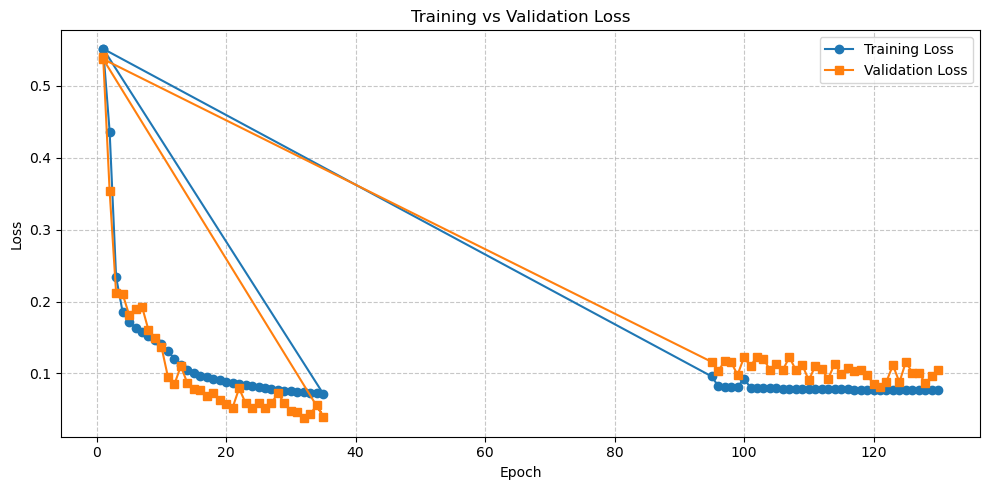

In [ ]:
import pandas as pd

# Load the uploaded CSV file
file_path = "data/performance_monitor_4_8.csv"
df = pd.read_csv(file_path)

import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Training_Loss'], label='Training Loss', marker='o')
plt.plot(df['Epoch'], df['Validation_Loss'], label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()